<a href="https://colab.research.google.com/github/Kunikan4629/Kaggle_Titanic/blob/main/CBD_Titanic_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ageの欠損値を埋める方法ごとにスコアがどう変動するか調べる**  
※Age, Cabin, Embarkedの値の一部は欠損  
※訓練データのクロスバリゼーションでのみモデルの精度を評価  
※特徴量エンジニアリングの参考文献は[こちら](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial#3.-Model)

変数 |定義 |備考  
---|---|---
Survived |死亡したかどうか |0 = No, 1 = Yes
Pclass |チケットのクラス |1 = 1st, 2 = 2nd, 3 = 3rd
Name |名前 |
Sex |性別 |
Age	|年齢 |
SibSp |乗船していた兄弟姉妹・配偶者の数	|
Parch |乗船していた親・子供の数	|
Ticket |チケット番号	|
Fare |チケット料金	|
Cabin |キャビン番号	|
embarked |乗船した港	|C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from google.colab import files

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Titanic/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [ ]:
df.head(8)
# Independent : pclass, name, sex, Embarked, passengerID, SibSp, parch, ticket, fare, and cabin
# Dependent : survived (True or False)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S

In [ ]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

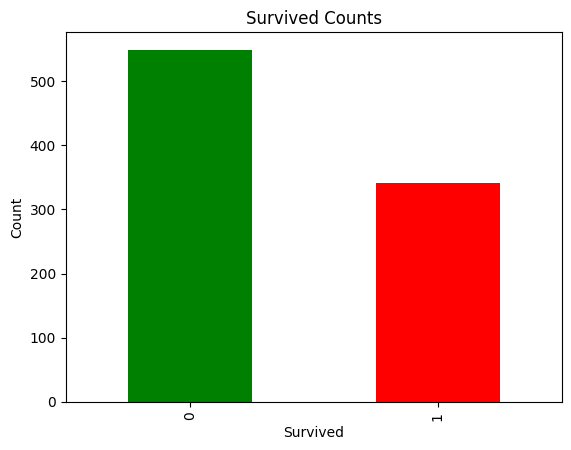

In [ ]:
survived_counts = df['Survived'].value_counts()
survived_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Survived Counts')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

In [ ]:
# Embarkedは欠損値が2件のみなので最頻値で対処
# これは全体へのインパクトが薄いので放置
df['Embarked'].fillna('S', inplace=True)
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [ ]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [ ]:
# カテゴリカルデータ処理
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
embarked_ohe = pd.get_dummies(df['Embarked'])
df = pd.concat([df, embarked_ohe], axis=1)
df.drop('Embarked', axis=1, inplace=True)
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare Cabin  C  Q  S  
0         A/5 21171   7.2500   NaN  0  0  1  
1          PC 17599  71.2833   C85  1  0  0  
2  STON/O2. 3101282   7.9250   NaN  0  0  1  
3            113803  53.1000  C123  0  0  1  
4            373450   8.0500   NaN  0  0  1

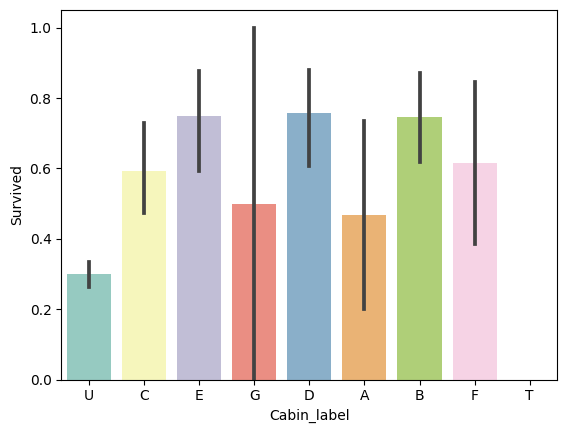

In [ ]:
# Cabinは欠損値が８割
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

In [ ]:
df.drop('Cabin', axis=1, inplace=True)
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  C  Q  S Cabin_label  
0         A/5 21171   7.2500  0  0  1           U  
1          PC 17599  71.2833  1  0  0           C  
2  STON/O2. 3101282   7.9250  0  0  1           U  
3            113803  53.1000  0  0  1           C  
4            373450   8.0500  0  0  1           U

In [ ]:
# Kaggleの上位入賞者のコードを参考

# Ticketの登場回数ごとにカラムを作成
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
# 名前から敬称と結婚しているかどうか抽出
df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df['Is_Married'] = 0
df['Is_Married'].loc[df['Title'] == 'Mrs'] = 1
# 名前を分類
df['Title'] = df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [ ]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
df.drop('SibSp', axis=1, inplace=True)
df.drop('Parch', axis=1, inplace=True)
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)

Title_ohe = pd.get_dummies(df['Title'])
df = pd.concat([df, Title_ohe], axis=1)
df.drop('Title', axis=1, inplace=True)
df.head()

PassengerId  Survived  Pclass  Sex   Age     Fare  C  Q  S Cabin_label  \
0            1         0       3    0  22.0   7.2500  0  0  1           U   
1            2         1       1    1  38.0  71.2833  1  0  0           C   
2            3         1       3    1  26.0   7.9250  0  0  1           U   
3            4         1       1    1  35.0  53.1000  0  0  1           C   
4            5         0       3    0  35.0   8.0500  0  0  1           U   

   Ticket_Frequency  Is_Married  Family_Size  Dr/Military/Noble/Clergy  \
0                 1           0            2                         0   
1                 1           1            2                         0   
2                 1           0            1                         0   
3                 2           1            2                         0   
4                 1           0            1                         0   

   Master  Miss/Mrs/Ms  Mr  
0       0            0   1  
1       0            1   0  
2       0            1   0  
3       0            1   0  
4       0            0   1

In [ ]:
Cabin_ohe = pd.get_dummies(df['Cabin_label'])
df = pd.concat([df, Cabin_ohe], axis=1)
df.drop('Cabin_label', axis=1, inplace=True)
df.head()

PassengerId  Survived  Pclass  Sex   Age     Fare  C  Q  S  \
0            1         0       3    0  22.0   7.2500  0  0  1   
1            2         1       1    1  38.0  71.2833  1  0  0   
2            3         1       3    1  26.0   7.9250  0  0  1   
3            4         1       1    1  35.0  53.1000  0  0  1   
4            5         0       3    0  35.0   8.0500  0  0  1   

   Ticket_Frequency  ...  Mr  A  B  C  D  E  F  G  T  U  
0                 1  ...   1  0  0  0  0  0  0  0  0  1  
1                 1  ...   0  0  0  1  0  0  0  0  0  0  
2                 1  ...   0  0  0  0  0  0  0  0  0  1  
3                 2  ...   0  0  0  1  0  0  0  0  0  0  
4                 1  ...   1  0  0  0  0  0  0  0  0  1  

[5 rows x 25 columns]

In [ ]:
df.isnull().sum()

PassengerId                   0
Survived                      0
Pclass                        0
Sex                           0
Age                         177
Fare                          0
C                             0
Q                             0
S                             0
Ticket_Frequency              0
Is_Married                    0
Family_Size                   0
Dr/Military/Noble/Clergy      0
Master                        0
Miss/Mrs/Ms                   0
Mr                            0
A                             0
B                             0
C                             0
D                             0
E                             0
F                             0
G                             0
T                             0
U                             0
dtype: int64

In [ ]:
# Ageの処理方法ごとに、データフレームを複製

# 欠損値削除
df_drop = df.copy()
# 全体の平均値を代入
df_mean = df.copy()
# PclassとSexのグループごとに平均値を代入
df_grouped_mean = df.copy()
# 予測値で代入
df_predict = df.copy()

In [ ]:
# Ageの欠損値削除
df_drop.dropna(subset=['Age'], inplace=True)
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               714 non-null    int64  
 1   Survived                  714 non-null    int64  
 2   Pclass                    714 non-null    int64  
 3   Sex                       714 non-null    int64  
 4   Age                       714 non-null    float64
 5   Fare                      714 non-null    float64
 6   C                         714 non-null    uint8  
 7   Q                         714 non-null    uint8  
 8   S                         714 non-null    uint8  
 9   Ticket_Frequency          714 non-null    int64  
 10  Is_Married                714 non-null    int64  
 11  Family_Size               714 non-null    int64  
 12  Dr/Military/Noble/Clergy  714 non-null    uint8  
 13  Master                    714 non-null    uint8  
 14  Miss/Mrs/M

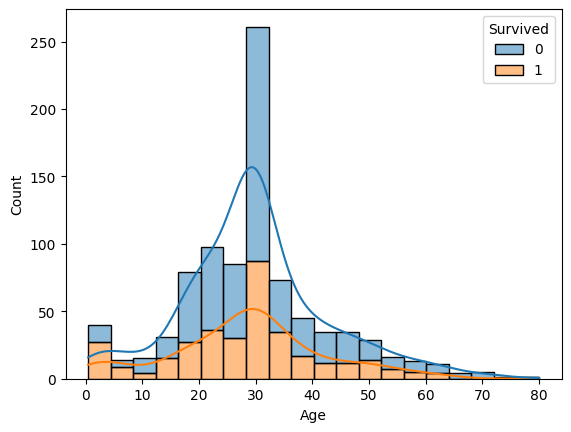

In [ ]:
# 全体の平均値を代入
age = df_mean['Age'].mean()
df_mean['Age'].fillna(age, inplace=True)
sns.histplot(data=df_mean, x='Age', hue='Survived', multiple='stack', bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<Figure size 1200x600 with 0 Axes>

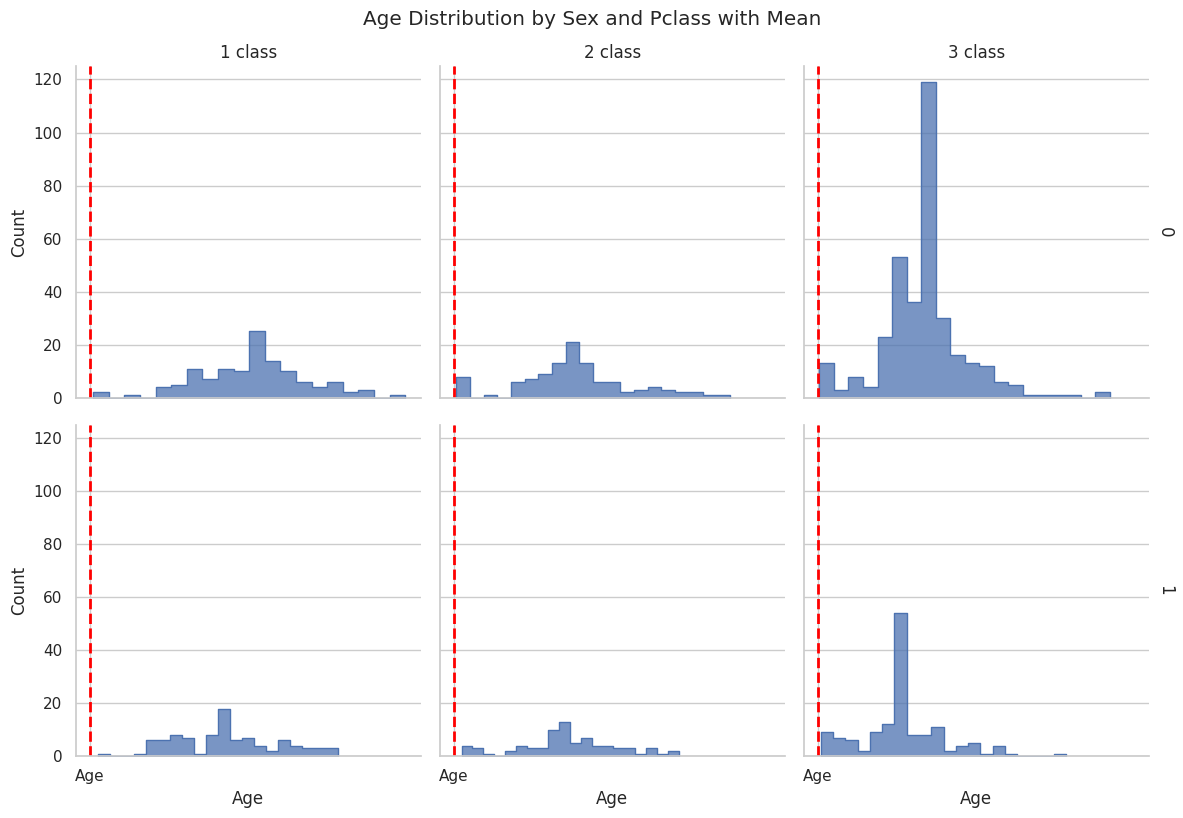

In [ ]:
# グループごとにAgeの欠損値を平均値で補ったデータフレーム df_grouped_mean を作成

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
g = sns.FacetGrid(df_grouped_mean, col="Pclass", row="Sex", margin_titles=True, height=4)
g.map(sns.histplot, "Age", bins=20, kde=False, element='step', stat='count', palette='Set1')
g.set_axis_labels("Age", "Count")
g.set_titles(col_template="{col_name} class", row_template="{row_name}")

# 各グループごとの平均値を表示する
g.map(plt.axvline, x='Age', color='red', linestyle='dashed', linewidth=2)

plt.suptitle('Age Distribution by Sex and Pclass with Mean', y=1.02)
plt.savefig('Titanic_Age_Distribution_with_Mean.png')
files.download("Titanic_Age_Distribution.png")
plt.show()


In [ ]:
df_grouped_mean.groupby(['Sex', 'Pclass'])['Age'].mean()

Sex  Pclass
0    1         41.281386
     2         30.740707
     3         26.507589
1    1         34.611765
     2         28.722973
     3         21.750000
Name: Age, dtype: float64

In [ ]:
files.download("Titanic_Age_Distribution.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

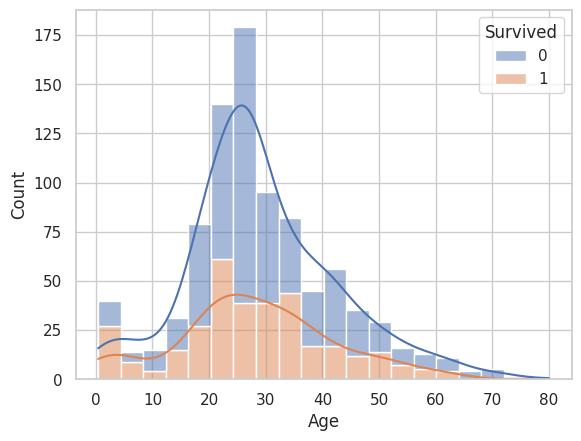

In [ ]:
df_grouped_mean['Age'] = df_grouped_mean.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.mean()))
sns.histplot(data=df_grouped_mean, x='Age', hue='Survived', multiple='stack', bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [ ]:
age_df.head()

PassengerId  Survived  Pclass  Sex   Age     Fare  C  Q  S  \
0            1         0       3    0  22.0   7.2500  0  0  1   
1            2         1       1    1  38.0  71.2833  1  0  0   
2            3         1       3    1  26.0   7.9250  0  0  1   
3            4         1       1    1  35.0  53.1000  0  0  1   
4            5         0       3    0  35.0   8.0500  0  0  1   

   Ticket_Frequency  ...  Mr  A  B  C  D  E  F  G  T  U  
0                 1  ...   1  0  0  0  0  0  0  0  0  1  
1                 1  ...   0  0  0  1  0  0  0  0  0  0  
2                 1  ...   0  0  0  0  0  0  0  0  0  1  
3                 2  ...   0  0  0  1  0  0  0  0  0  0  
4                 1  ...   1  0  0  0  0  0  0  0  0  1  

[5 rows x 25 columns]

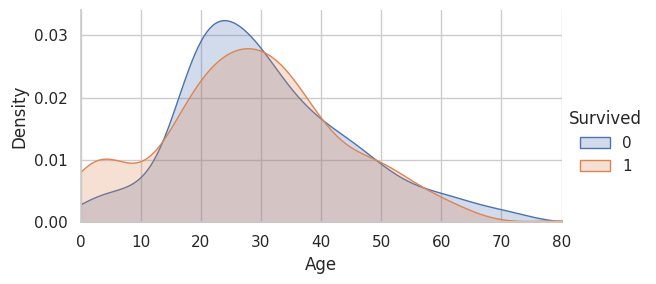

In [ ]:
# Ageの欠損値を予測で補う
##[['Age','Pclass','Sex','Family_Size']]
age_df = df_predict
target_col = "Age"
df_target = age_df[target_col]
age_df = age_df.drop(target_col, axis=1)
age_df.insert(0, target_col, df_target)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values
X = known_age[:, 1:]
y = known_age[:,0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df_predict.loc[(df_predict.Age.isnull()), 'Age'] = predictedAges

facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_predict.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

In [ ]:
# それぞれ説明変数と目的変数を抽出
X_drop = df_drop.iloc[:, 2:].values
y_drop = df_drop.iloc[:, 1].values

X_mean = df_mean.iloc[:, 2:].values
y_mean = df_mean.iloc[:, 1].values

X_grouped_mean = df_grouped_mean.iloc[:, 2:].values
y_grouped_mean = df_grouped_mean.iloc[:, 1].values

X_predict = df_predict.iloc[:, 2:].values
y_predict = df_predict.iloc[:, 1].values

In [ ]:
# それぞれ決定木で予測
# クロスバリゼーションで評価
rfc_drop = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_drop.fit(X_drop, y_drop)
cv_result_drop = cross_validate(rfc_drop, X_drop, y_drop, cv= 10)
print('欠損値削除')
print('mean_score = ', np.mean(cv_result_drop['test_score']))
print('mean_std = ', np.std(cv_result_drop['test_score']))


rfc_mean = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_mean.fit(X_mean, y_mean)
cv_result_mean = cross_validate(rfc_mean, X_mean, y_mean, cv= 10)
print('平均値を代入')
print('mean_score = ', np.mean(cv_result_mean['test_score']))
print('mean_std = ', np.std(cv_result_mean['test_score']))


rfc_grouped_mean = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_grouped_mean.fit(X_grouped_mean, y_grouped_mean)
cv_result_grouped_mean = cross_validate(rfc_grouped_mean, X_grouped_mean, y_grouped_mean, cv= 10)
print('グループごとに平均値を代入')
print('mean_score = ',np.mean(cv_result_grouped_mean['test_score']))
print('mean_std = ', np.std(cv_result_grouped_mean['test_score']))


rfc_predict = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_predict.fit(X_predict, y_predict)
cv_result_predict = cross_validate(rfc_predict, X_predict, y_predict, cv= 10)
print('予測値を代入')
print('mean_score = ', np.mean(cv_result_predict['test_score']))
print('mean_std = ', np.std(cv_result_predict['test_score']))


欠損値削除
mean_score =  0.8096635367762129
mean_std =  0.036905634158174085
平均値を代入
mean_score =  0.828314606741573
mean_std =  0.04754495410955972
グループごとに平均値を代入
mean_score =  0.8294382022471911
mean_std =  0.04445180121188495
予測値を代入
mean_score =  0.8372908863920101
mean_std =  0.05069740450173517


上記の結果を最終的な実験結果として採用する


In [ ]:
# # グリッドサーチ法を用いたランダムフォレスト
# param_grid = {'max_depth': [6, 7, 8, 9, 10],
#               'min_samples_leaf': [1, 2, 3, 4, 5]}
# rfc = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
# rfc.fit(X, y)
# print('Best Parameters: {}'.format(rfc.best_params_))
# print('CV Score: {}'.format(round(rfc.best_score_, 3)))



In [ ]:
# # データ確認
# submission = pd.read_csv(path + 'gender_submission.csv')
# submission['Perished'] = pred
# submission

<Axes: >

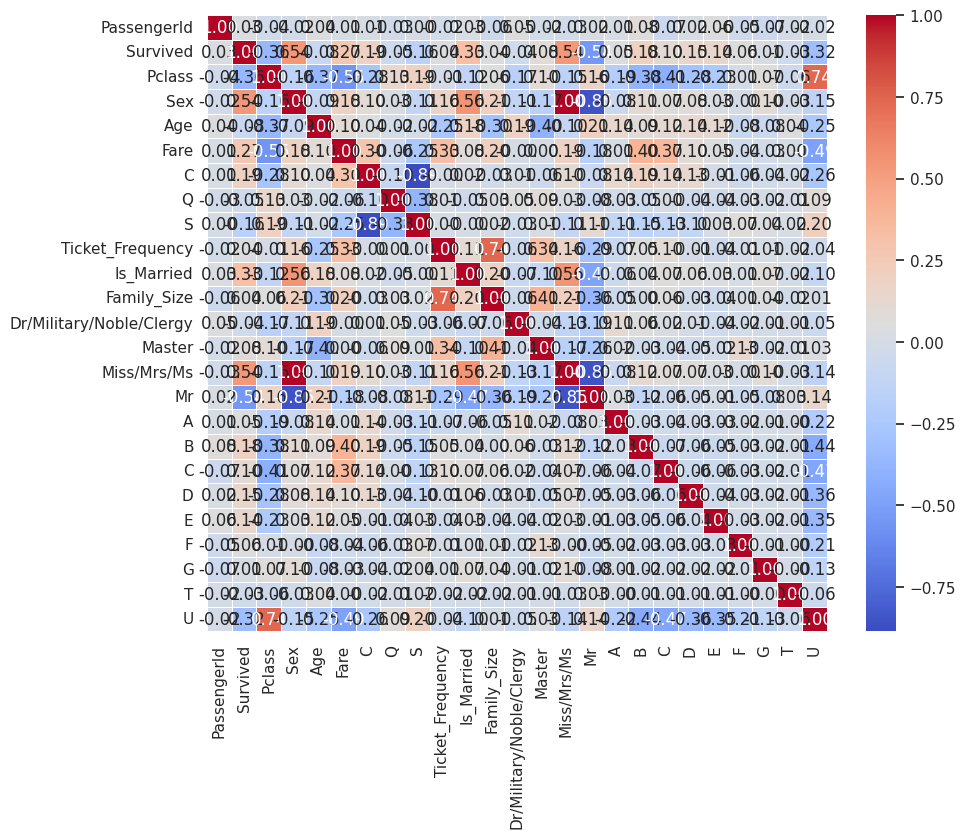

In [ ]:
df_drop = df_drop[['PassengerId', 'Survived']]
correlation_matrix = df_drop.corr()

# ヒートマップを作成
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)